In [49]:
import numpy as np
import pandas as pd
import virga.justdoit as jdi
import matplotlib.pyplot as plt
import astropy.units as u

In [50]:
from bokeh.io import output_notebook 
from bokeh.plotting import show, figure
from bokeh.palettes import Colorblind
output_notebook()
import numpy as np
import pandas as pd
import astropy.units as u

#here is virga
import virga.justdoit as jdi
refrind_dir = '/home/sansar1/Codes/cloud_model/virga/virga/mieffs'

Loading BokehJS ...

In [51]:
def input_reader(input_file):
    input_data = []
    with open(input_file, "r") as f:
        lines = f.readlines()
        T_eff = float(lines[0])
        gravity = float(lines[1])
        num_layers = int(lines[2])
        for line in lines[4:]:
            parts = line.strip().split()
            input_data.append([float(x.replace("E", "e")) for x in parts])
        return T_eff, gravity, num_layers, np.array(input_data)

T_eff, gravity, num_layers, input_data = input_reader("/home/sansar1/Codes/cloud_model/input/profiles/voyager.input")
#input_data = input_data[input_data[:,1].argsort()]

In [52]:
mieff_directory =  '//home/sansar1/Codes/cloud_model/virga/virga/mieffs'

In [53]:
fsed = 1
metallicity = 1 #atmospheric metallicity relative to Solar
mean_molecular_weight = 2.2 # atmospheric mean molecular weight

In [54]:
import pandas as pd
df = pd.DataFrame(input_data, columns=["Temperature (K)", "Pressure (bar)"])
print(df.head())
df = df.sort_values(by="Pressure (bar)").reset_index(drop=True)

   Temperature (K)  Pressure (bar)
0            168.8         0.00112
1            160.7         0.00126
2            152.8         0.00141
3            151.4         0.00158
4            152.3         0.00178


In [55]:
df = df.rename(columns={ "Pressure (bar)": "pressure", 
                        "Temperature (K)": "temperature"})

In [56]:
r_atmos = 8.3143e7 / 2.2
STEFBOLTZ = 5.67051e-5
chf = STEFBOLTZ * T_eff ** 4
df["chf"] = chf * np.ones(len(df))

In [57]:
df = df[['pressure', 'temperature', 'chf']]
df.head()

,pressure,temperature,chf
0,0.00112,168.8,13580.121079
1,0.00126,160.7,13580.121079
2,0.00141,152.8,13580.121079
3,0.00158,151.4,13580.121079
4,0.00178,152.3,13580.121079


In [58]:
sum_planet = jdi.Atmosphere(['NH3'],fsed=fsed,mh=metallicity,
                 mmw = mean_molecular_weight)
cmps2 = u.cm / u.s**2
sum_planet.gravity(gravity=gravity, gravity_unit=cmps2)
sum_planet.ptk(df = df, latent_heat=True, convective_overshoot=1/3.)
out_latent_cos = sum_planet.compute(as_dict=True,
                               directory=mieff_directory)

In [59]:
out_latent_cos.keys()

dict_keys(['pressure', 'pressure_unit', 'temperature', 'temperature_unit', 'wave', 'wave_unit', 'condensate_mmr', 'cond_plus_gas_mmr', 'mean_particle_r', 'droplet_eff_r', 'r_units', 'column_density', 'column_density_unit', 'opd_per_layer', 'single_scattering', 'asymmetry', 'opd_by_gas', 'condensibles', 'scalar_inputs', 'fsed', 'altitude', 'layer_thickness', 'z_unit', 'mixing_length', 'mixing_length_unit', 'kz', 'kz_unit', 'scale_height', 'cloud_deck'])

In [60]:
# Read voyager_frain1_sig2.out
file = "/home/sansar1/Codes/cloud_model/output/voyager_frain1_sig2.out"
voyager = []
with open(file, "r") as f:
    lines = f.readlines()
    for line in lines[3:]:
        parts = line.strip().split()
        voyager.append([float(x.replace("E", "e")) for x in parts])
voyager = np.array(voyager)

print(voyager[:,4].shape)

(312,)


/tmp/ipykernel_8506/2835755263.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(qc), P, marker='o')
/tmp/ipykernel_8506/2835755263.py:5: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(voyager[:,4]), voyager[:,1]*(10**(-6)), marker='o')


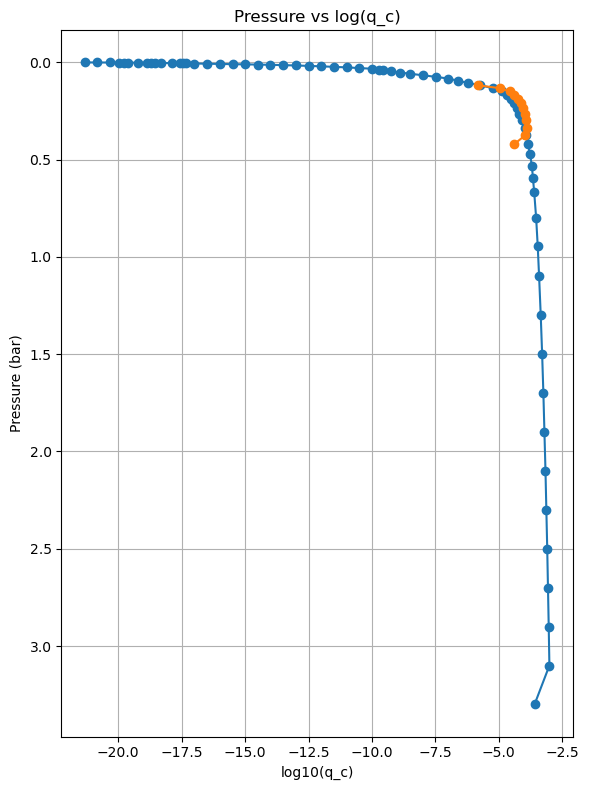

In [61]:
qc = out_latent_cos['condensate_mmr']
P = out_latent_cos['pressure']
plt.figure(figsize=(6, 8))
plt.plot(np.log10(qc), P, marker='o')
plt.plot(np.log10(voyager[:,4]), voyager[:,1]*(10**(-6)), marker='o')

plt.gca().invert_yaxis()  # invert pressure axis
plt.xlabel("log10(q_c)")
plt.ylabel("Pressure (bar)")  
plt.title("Pressure vs log(q_c)")
plt.grid(True)
plt.tight_layout()
plt.show()

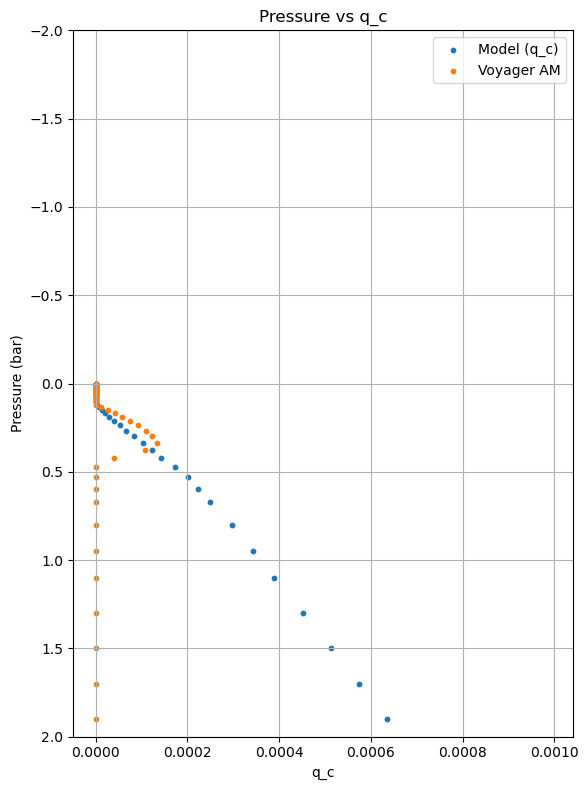

In [62]:
qc = out_latent_cos['condensate_mmr']
P = out_latent_cos['pressure']
plt.figure(figsize=(6, 8))
plt.scatter(qc, P, s=10, label='Model (q_c)')   
plt.scatter(voyager[:,4], voyager[:,1]*(1e-6), s=10, label='Voyager AM')
plt.ylim(-2, 2)
plt.gca().invert_yaxis() # invert pressure axis
plt.xlabel("q_c")
plt.ylabel("Pressure (bar)")  
plt.title("Pressure vs q_c")


plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [63]:
#print(qc)
print(np.shape(qc))

(312, 1)


In [64]:
# make them 1D
qc_flat = np.ravel(qc)
P_flat = np.ravel(P)
# Masks for zeros and negatives
zero_mask = qc_flat == 0
neg_mask  = qc_flat < 0

# Zero values
print(f"\nNumber of zero qc values: {np.sum(zero_mask)}")
if np.any(zero_mask):
    print("Indices (zero qc):", np.where(zero_mask)[0])
    print("qc values (should all be 0):", qc_flat[zero_mask])
    print("Pressures at zero qc:", P_flat[zero_mask])

# Negative values
print(f"\nNumber of negative qc values: {np.sum(neg_mask)}")
if np.any(neg_mask):
    print("Indices (negative qc):", np.where(neg_mask)[0])
    print("qc values (negative):", qc_flat[neg_mask])
    print("Pressures at negative qc:", P_flat[neg_mask])



Number of zero qc values: 242
Indices (zero qc): [ 70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87
  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105
 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123
 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141
 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159
 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177
 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195
 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213
 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231
 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249
 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267
 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285
 286 287 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303
 

In [65]:
nonzero_mask = qc_flat > 0
p_nonzero = P_flat[nonzero_mask]
if np.any(nonzero_mask):
    p_top = np.min(p_nonzero)
    p_base = np.max(p_nonzero)
    print(f"Cloud forms between {p_top:.3f} and {p_base:.3f} bar")
else:
    print("No cloud formed in this profile.")



Cloud forms between 0.001 and 3.300 bar


In [66]:
qc_flat = np.ravel(voyager[:,4])
P_flat = np.ravel(voyager[:,1]*(1e-6))
zero_mask = qc_flat == 0
neg_mask  = qc_flat < 0

# Zero values
print(f"\nNumber of zero qc values: {np.sum(zero_mask)}")
if np.any(zero_mask):
    print("Indices (zero qc):", np.where(zero_mask)[0])
    print("qc values (should all be 0):", qc_flat[zero_mask])
    print("Pressures at zero qc:", P_flat[zero_mask])

# Negative values
print(f"\nNumber of negative qc values: {np.sum(neg_mask)}")
if np.any(neg_mask):
    print("Indices (negative qc):", np.where(neg_mask)[0])
    print("qc values (negative):", qc_flat[neg_mask])
    print("Pressures at negative qc:", P_flat[neg_mask])



Number of zero qc values: 300
Indices (zero qc): [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  52  53  54  55  56  57  58  59  60  61  62  63  64  65
  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83
  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101
 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119
 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137
 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155
 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173
 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191
 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209
 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227
 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245
 

In [67]:
nonzero_mask = qc_flat > 0
p_nonzero = P_flat[nonzero_mask]
if np.any(nonzero_mask):
    p_top = np.min(p_nonzero)
    p_base = np.max(p_nonzero)
    print(f"Cloud forms between {p_top:.3f} and {p_base:.3f} bar")
else:
    print("No cloud formed in this profile.")


Cloud forms between 0.119 and 0.422 bar
